# Маркетинговая аналитика Яндекс.Афиши


Оглавление:
1. [Загрузка и подготовка данных к анализу](#prepare)
2. [Исследовательский анализ данных](#eda)
    - [Продуктовые метрики](#product_metrics)
    - [Метрики электронной коммерции](#commerce_metrics)
    - [Маркетинговые метрики](#marketing_metrics)
3. [Выводы](#conclusions)


**Цель проекта**: проанализировать данные о посещениях сайта, заказах, расходах на рекламу за период с июня 2017 по конец мая 2018 года, выявить на основе этих данных невыгодные источники трафика и перераспределить бюджет. 

Для этого изучения требуют следующие вопросы:
1. Как клиенты пользуются сервисом
2. Когда делают первые покупки на сайте
3. Сколько денег компании приносит каждый клиент
4. Когда расходы на привлечение клиента окупаются



In [1]:
import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных к анализу<a id = 'prepare'><a/>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy import stats as st
from math import factorial

In [3]:
import os

In [4]:
#прочитаем данные
path = 'C:/Python/datasets/'
if os.path.exists(path):
    visits = pd.read_csv(path + 'visits_log.csv')
else:
    visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
path = 'C:/Python/datasets/'
if os.path.exists(path):
    orders = pd.read_csv(path + 'orders_log.csv')
else:
    orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
path = 'C:/Python/datasets/'
if os.path.exists(path):
    expenses = pd.read_csv(path + 'costs.csv')
else:
    expenses = pd.read_csv('/datasets/costs.csv')
expenses.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Таблица visits хранит лог сервера с информацией о посещениях сайта, таблица orders - информацию о заказах, таблица expenses - информацию о расходах на маркетинг. 

В таблице visits представлены следующие столбцы:
-	**Uid** — уникальный идентификатор пользователя,
-	**Device** — категория устройства пользователя,
-	**Start Ts** — дата и время начала сессии,
-	**End Ts** — дата и время окончания сессии,
-	**Source Id** — идентификатор источника перехода на сайт.

В таблице orders:
-	**Uid** — уникальный идентификатор пользователя,
-	**Buy Ts** — дата и время заказа,
-	**Revenue** — сумма заказа.

В таблице expenses:
-	**source_id** — идентификатор рекламного источника,
-	**dt** — дата проведения рекламной кампании,
-	**costs** — расходы на эту кампанию.


### Данные таблицы visits

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Пропуски в данных отсутствуют. 

Изменим названия столбцов, приведя все названия к нижнему регистру:

In [8]:
visits.rename(columns = {'Device':'device', 'End Ts':'end_ts', 'Source Id':'source_id', 'Start Ts':'start_ts', 
                        'Uid':'uid'}, inplace = True)

Типы данных в столбцах с датой о начале и конце сессии следует привести к временному формату:

In [9]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Посмотрим на наличие дупликатов:

In [11]:
visits.duplicated().sum()

0

### Данные таблицы orders

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Пропусков в таблице нет. 

По аналогии с данными о визитах, приведем названия столбцов к нижнему регистру:

In [13]:
orders.rename(columns = {'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'}, inplace = True)

Заменим тип данных в столбце buy_ts:

In [14]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Посмотрим на наличие дупликатов:

In [16]:
orders.duplicated().sum()

0

### Данные таблицы expenses

In [17]:
expenses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Данные не содержат пропусков. Названия столбцов не требуют приведения к нижнему регистру. Заменим тип данных в столбце dt:

In [18]:
expenses['dt'] = pd.to_datetime(expenses['dt'])

Посмотрим на наличие дупликатов:

In [19]:
expenses.duplicated().sum()

0

Данные готовы к анализу. Пропусков и дупликатов нет. Типы данных соответствуют содержимому. 

## Исследовательский анализ данных<a id = 'eda'><a/>
    


### Продуктовые метрики<a id = 'product_metrics'><a/>

К продуктовым метрикам относятся такие метрики, как: 

- DAU(Daily Active Users)
- WAU (Weekly Active Users)
- MAU (Monthly Active Users)

Данные метрики сообщают о количестве уникальных пользователей. За ними полезно следить для общего понимания ситуации. 

Для начала добавим в таблицу visits столбцы с годом, месяцем, неделей и датой:

In [20]:
visits['date'] = visits['start_ts'].dt.date
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['year'] = visits['start_ts'].dt.year
visits.head()

,device,end_ts,source_id,start_ts,uid,date,month,week,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,12,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,7,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,5,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,12,52,2017


Далее найдем количество уникальных пользователей заходящих на сайт за день, за неделю и за месяц.

In [21]:
dau = visits.groupby('date').agg({'uid':'nunique'})
wau = visits.groupby(['year', 'week']).agg({'uid':'nunique'})
mau = visits.groupby(['year', 'month']).agg({'uid':'nunique'})
print('DAU:', float(dau.mean()))
print('MAU:', float(mau.mean()))
print('WAU:', float(wau.mean()))

DAU: 907.9917582417582
MAU: 23228.416666666668
WAU: 5716.245283018868


Отобразим их изменения на графике:

In [22]:
dau = dau.reset_index()
wau = wau.reset_index()
mau = mau.reset_index()
dau.rename(columns = {'uid':'active_users'}, inplace = True)
mau.rename(columns = {'uid':'active_users'}, inplace = True)
wau.rename(columns = {'uid':'active_users'}, inplace = True)


Для того, чтобы построить графики, объединим столбцы с годом и неделей/месяцем в один столбец и преобразуем к формату даты:

In [23]:
mau['year'] = mau['year'].astype('str')
mau['month'] = mau['month'].astype('str')


In [24]:
mau['datetime'] = pd.to_datetime(mau.year + '-' + mau.month, format='%Y-%m')
mau

,year,month,active_users,datetime
0,2017,6,13259,2017-06-01
1,2017,7,14183,2017-07-01
2,2017,8,11631,2017-08-01
3,2017,9,18975,2017-09-01
4,2017,10,29692,2017-10-01
5,2017,11,32797,2017-11-01
6,2017,12,31557,2017-12-01
7,2018,1,28716,2018-01-01
8,2018,2,28749,2018-02-01
9,2018,3,27473,2018-03-01


In [25]:
wau['year'] = wau['year'].astype('str')
wau['week'] = wau['week'].astype('str')



In [26]:
wau['datetime'] = pd.to_datetime(wau.year +'-'+ wau.week +'-'+ '0', format='%Y-%W-%w')
wau

,year,week,active_users,datetime
0,2017,22,2021,2017-06-04
1,2017,23,4129,2017-06-11
2,2017,24,2812,2017-06-18
3,2017,25,2878,2017-06-25
4,2017,26,3064,2017-07-02
5,2017,27,3294,2017-07-09
6,2017,28,4355,2017-07-16
7,2017,29,3841,2017-07-23
8,2017,30,2655,2017-07-30
9,2017,31,2364,2017-08-06


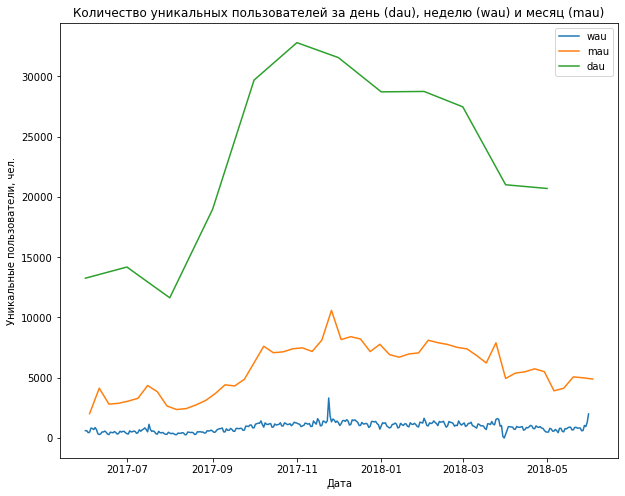

In [27]:
labels = {'mau', 'dau', 'wau'}
plt.figure(figsize = (10, 8))
sns.lineplot(x = 'date', y = 'active_users', data = dau)
sns.lineplot(x = 'datetime', y = 'active_users', data = wau)
ax = sns.lineplot(x = 'datetime', y = 'active_users', data = mau)
plt.legend(labels)
plt.title('Количество уникальных пользователей за день (dau), неделю (wau) и месяц (mau)')
ax.set_xlabel('Дата')
ax.set_ylabel('Уникальные пользователи, чел.')
plt.show()

**Таким образом, мы наблюдаем рост числа активных пользователей с августа 2017 по декабрь 2017 года и затем его снижение.**

Построим гистограмму для значений таблицы dau, где среднее значение DAU равно 907.99, чтобы отобразить частоту активных пользователей на сайте в течение исследуемого периода.

In [28]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in c:\python\anaconda\lib\site-packages (0.11.2)


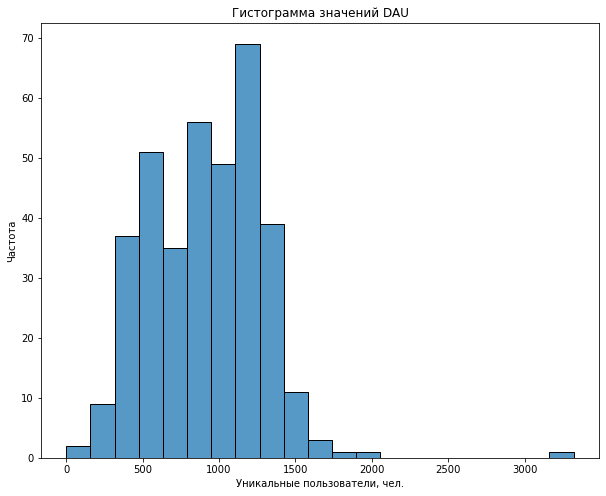

In [29]:

plt.figure(figsize = (10, 8))
ax = sns.histplot(data=dau, x="active_users")
plt.title('Гистограмма значений DAU')
ax.set_ylabel('Частота')
ax.set_xlabel('Уникальные пользователи, чел.')
plt.show()

**Исходя из гистограммы видно, что распределение близко к нормальному, однако наблюдаются выбросы со значениями более 2000 пользователей в день, что можно наблюдать как отдельный пик в декабре 2017 года на графике выше.**

Далее посмотрим, сколько времени в среднем пользователи проводят на сайте. Узнаем продолжительность типичной сессии (ASL) за весь период. 

In [30]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration'].mean()

643.506488592098

Среднее значение пользовательской сессии - 643 секунды. Однако, стоит посмотреть на распределение значений данного показателя:

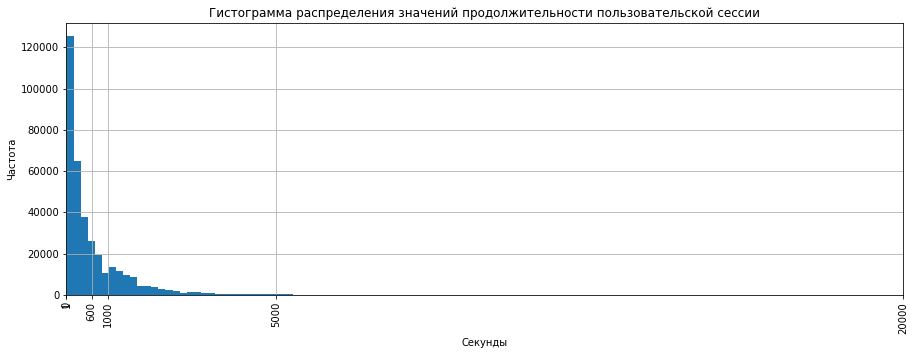

In [31]:
plt.figure(figsize = (15, 5))
ax = visits['session_duration'].hist(bins = 500)
ax.set_xticks([0, 1, 600, 1000, 5000, 20000, 40000, 60000, 80000]) 
ax.set_xlabel('Секунды')
ax.set_ylabel("Частота")
plt.title('Гистограмма распределения значений продолжительности пользовательской сессии')
plt.xticks(rotation=90)
plt.xlim([0, 20000])
plt.show()


Сфокусируемся на интервале от 0 до 5000:

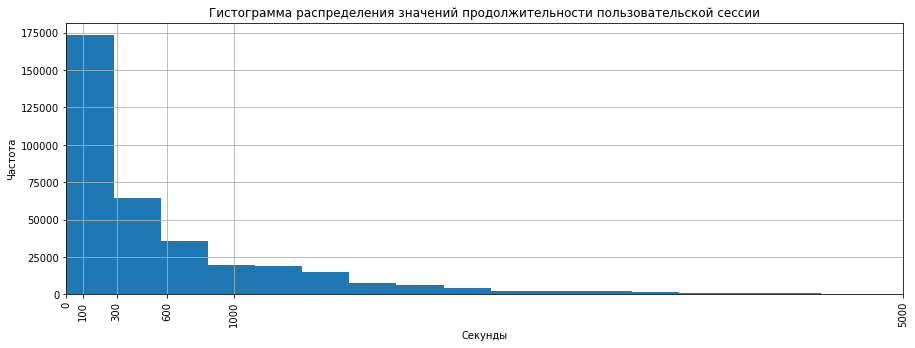

In [32]:
plt.figure(figsize = (15, 5))
ax = visits['session_duration'].hist(bins = 300)
ax.set_xticks([0, 100, 300, 600, 1000, 5000, 20000, 40000, 60000, 80000]) 
plt.xticks(rotation=90)
plt.xlim([0, 5000])
ax.set_xlabel('Секунды')
ax.set_ylabel("Частота")
plt.title('Гистограмма распределения значений продолжительности пользовательской сессии')
plt.show()


Данные сильно скошены влево, то есть огромное число пользовательских сессий имеют продолжительностью от 0 до 300 секунд. Посмотрим на значение моды:

In [33]:
visits['session_duration'].mode()

0    60
dtype: int64

**Таким образом, можно заключить, что больше всего сессий дляться одну минуту.** 

#### Когортный анализ

Рассчитаем коэффициент удержания пользователей, Retention Rate. Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды.

Для начала сформируем когорты по месяцам на основе данные о визитах. 

In [34]:
#найдем даты первой активности для отдельных пользователей:
first_activity_date  = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'

In [35]:
visits = visits.join(first_activity_date, on = 'uid')

In [36]:
#Добавим столбцы с месяцами:
visits['first_activity_month'] = visits['first_activity_date'].astype(
    'datetime64[M]'
)
visits['activity_month'] = visits['date'].astype('datetime64[M]')


Сформируем сводную таблицу по когортам:

In [37]:
cohorts_grouped = visits.groupby(['first_activity_month', 'activity_month']).agg({'uid':'nunique'}).reset_index()
cohorts_grouped.rename(columns = {'uid':'active_users'}, inplace = True)
cohorts_grouped.head()

,first_activity_month,activity_month,active_users
0,2017-06-01,2017-06-01,13259
1,2017-06-01,2017-07-01,1043
2,2017-06-01,2017-08-01,713
3,2017-06-01,2017-09-01,814
4,2017-06-01,2017-10-01,909


Найдём lifetime когорт

In [38]:
#Найдем количество дней от начала образования когорты:
cohorts_grouped['cohort_lifetime'] = (
    cohorts_grouped['activity_month']
    - cohorts_grouped['first_activity_month']
)

#Найдем порядковые номера:
cohorts_grouped['cohort_lifetime'] = (cohorts_grouped['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int') 
cohorts_grouped['cohort_lifetime'].head()

0    0
1    1
2    2
3    3
4    4
Name: cohort_lifetime, dtype: int32

Получим исходное количество пользователей по когортам:

In [39]:
initial_users_count = cohorts_grouped[cohorts_grouped['cohort_lifetime'] == 0][
    ['first_activity_month', 'active_users']
]
initial_users_count.rename(columns={'active_users':'cohort_users'}, inplace = True)
initial_users_count.head()

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


Добавим получившиеся данные к сводной таблице:

In [40]:
cohorts_grouped = cohorts_grouped.merge(initial_users_count, on = 'first_activity_month')
cohorts_grouped.head(20)

,first_activity_month,activity_month,active_users,cohort_lifetime,cohort_users
0,2017-06-01,2017-06-01,13259,0,13259
1,2017-06-01,2017-07-01,1043,1,13259
2,2017-06-01,2017-08-01,713,2,13259
3,2017-06-01,2017-09-01,814,3,13259
4,2017-06-01,2017-10-01,909,4,13259
5,2017-06-01,2017-11-01,947,5,13259
6,2017-06-01,2017-12-01,809,6,13259
7,2017-06-01,2018-01-01,766,7,13259
8,2017-06-01,2018-02-01,694,8,13259
9,2017-06-01,2018-03-01,674,9,13259


Посчитаем Retention rate и визуализируем сводную таблицу со значениями данного показателя по когортам с помощью тепловой карты:

In [41]:
cohorts_grouped['retention'] = cohorts_grouped['active_users']/cohorts_grouped['cohort_users']
retention_pivot = cohorts_grouped.pivot_table(index = 'first_activity_month',
                                             columns = 'cohort_lifetime',
                                             values = 'retention',
                                             aggfunc = 'mean')

In [42]:
yticks_cohorts = retention_pivot.reset_index()
yticks_cohorts = yticks_cohorts['first_activity_month'].dt.date.astype('str')

<Figure size 720x720 with 0 Axes>

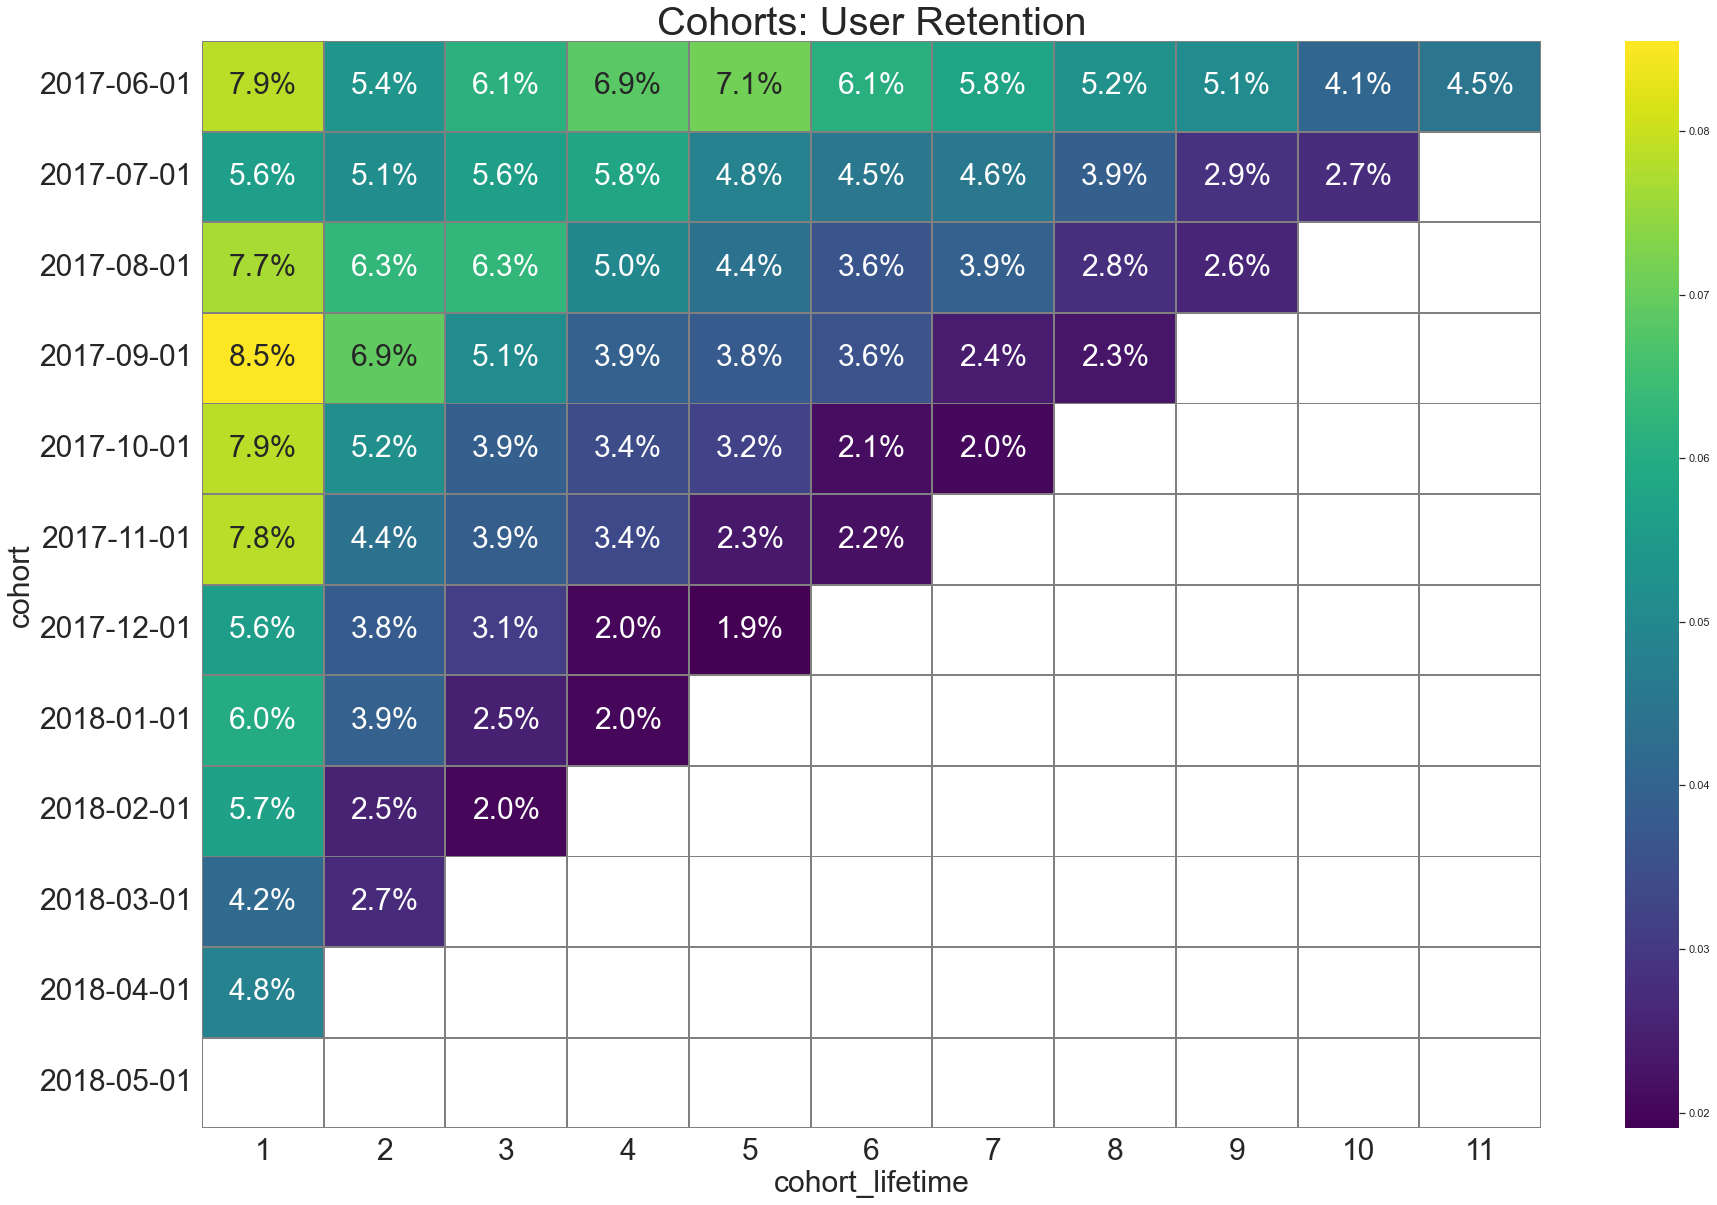

In [43]:
retention_pivot_plot = retention_pivot.loc[:, 1:11]

plt.figure(figsize = (10, 10))
sns.set(style='white')
plt.figure(figsize=(30, 20))
plt.title('Cohorts: User Retention', fontsize = 40)
ax = sns.heatmap(retention_pivot_plot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', 
                 cmap= 'viridis', annot_kws={"fontsize":30}, yticklabels = yticks_cohorts)
ax.tick_params(labelsize = 30)
plt.ylabel('cohort', fontsize=30)
plt.xlabel('cohort_lifetime', fontsize=30)
plt.yticks(rotation=0)
plt.show()



Посмотрим на среднее значение Retention Rate на второй месяц жизни когорт:

In [44]:
print('Средний Retention rate на второй месяц жизни когорт: {:.2%}'.format(retention_pivot[1].mean()))

Средний Retention rate на второй месяц жизни когорт: 6.52%


Огромное число пользователей не возвращаются. Коэффициент удержания очень низок и составляет около 6-8% после первого месяца, то есть более 90% пользователей уходят. 

Также, наблюдается уменьшение коэффициента удержания в более поздних когортах, что сигнализирует о том, что следует что-то менять, чтобы сохранить бизнес. Когорта июля 2017 года - наиболее успешная для компании, на 12-й месяц 4.5% пользователей остались, что почти в два раза выше показателей последних месяцов остальных когорт. 

### Метрики электронной коммерции<a id = 'commerce_metrics'><a/>

Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения первой покупки.

Для этого создадим срез таблицы visits с временем первого захода и присоединим к ней срез таблицы orders с данными первых покупок:

In [45]:
visits_first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
visits_first_visit['date'] = visits_first_visit['start_ts'].dt.date
visits_first_visit.head()

,uid,start_ts,date
0,11863502262781,2018-03-01 17:27:00,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06
2,297729379853735,2017-06-07 18:47:00,2017-06-07
3,313578113262317,2017-09-18 22:49:00,2017-09-18
4,325320750514679,2017-09-30 14:29:00,2017-09-30


In [46]:
orders_first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
orders_first_order['order_date'] = orders_first_order['buy_ts'].dt.date
orders_first_order.head()

,uid,buy_ts,order_date
0,313578113262317,2018-01-03 21:51:00,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-24


Сгруппируем данные по пользователям:

In [47]:
visits_orders = visits_first_visit.merge(orders_first_order, on = 'uid')
visits_orders.head()

,uid,start_ts,date,buy_ts,order_date
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2018-01-03 21:51:00,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-03 10:13:00,2017-06-03
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-11 18:33:00,2017-10-11
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-28 15:54:00,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-24 10:14:00,2017-11-24


Добавим столбец с разницей между временем первой покупки и временем первого визита:

In [48]:
visits_orders['interval_sec'] = (visits_orders['buy_ts'] - visits_orders['start_ts']).dt.seconds
visits_orders.sort_values(by = 'interval_sec').head()

,uid,start_ts,date,buy_ts,order_date,interval_sec
31544,15925826577084455011,2017-09-30 22:46:00,2017-09-30,2017-09-30 22:46:00,2017-09-30,0
18978,9602464566270845651,2018-05-08 15:25:00,2018-05-08,2018-05-08 15:25:00,2018-05-08,0
26214,13227354511227511807,2018-03-15 15:13:00,2018-03-15,2018-03-15 15:13:00,2018-03-15,0
12390,6190768087379704049,2017-08-30 10:15:00,2017-08-30,2017-08-30 10:15:00,2017-08-30,0
22168,11196073532503437379,2017-12-08 10:57:00,2017-12-08,2017-12-08 10:57:00,2017-12-08,0


Наблюдается очень большой разброс данного интервала. Нулевые значения выывают подозрения, посмотрим на распредеоение данных:

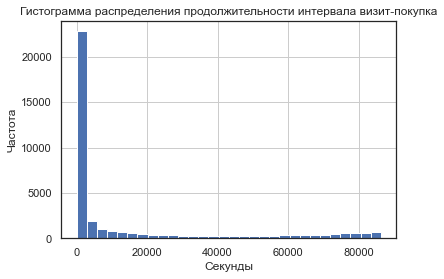

In [49]:
plt.figure()
ax = visits_orders['interval_sec'].hist(bins = 30)
plt.title('Гистограмма распределения продолжительности интервала визит-покупка')
ax.set_xlabel('Секунды')
ax.set_ylabel('Частота')
plt.show()

Посмотрим, каков процент нулевых значений данного интервала:

In [50]:
a = len(visits_orders[visits_orders['interval_sec'] == 0])/len(visits_orders['interval_sec'])
print('{:.2%}'.format(a))

6.75%


Возможно, это ошибка ввода данных, когда секунды не указываются, что можно наблюдать в таблице, где у всех нулевых значений интервала в поле значений секунд стоят нули. Скорее всего данные покупки были совершены в течение менее одной минуты. Для подтверждения нашего предположения посмотрим на следующее после 0 значение:

In [51]:
visits_orders.sort_values(by = 'interval_sec').query('interval_sec > 0').head()


,uid,start_ts,date,buy_ts,order_date,interval_sec
7255,3676227847830307844,2018-03-21 23:20:00,2018-03-21,2018-03-21 23:21:00,2018-03-21,60
7424,3756939472712452711,2018-02-08 14:42:00,2018-02-08,2018-02-08 14:43:00,2018-02-08,60
7256,3677162266552650977,2018-04-10 00:09:00,2018-04-10,2018-04-10 00:10:00,2018-04-10,60
33209,16767863096615402280,2017-09-08 10:52:00,2017-09-08,2017-09-08 10:53:00,2017-09-08,60
13721,6883313931537869093,2018-05-29 19:28:00,2018-05-29,2018-05-29 19:29:00,2018-05-29,60


In [52]:
visits_orders.sort_values(by = 'interval_sec').query('interval_sec > 60').head()

,uid,start_ts,date,buy_ts,order_date,interval_sec
15286,7675068411367518728,2017-09-04 14:41:00,2017-09-04,2017-09-04 14:43:00,2017-09-04,120
31636,15974676665349104064,2018-04-27 15:42:00,2018-04-27,2018-04-27 15:44:00,2018-04-27,120
11650,5839991835868333126,2017-07-09 21:24:00,2017-07-09,2017-07-09 21:26:00,2017-07-09,120
6065,3064658951185966160,2017-12-04 17:12:00,2017-12-04,2017-12-04 17:14:00,2017-12-04,120
16213,8133010201880666391,2017-10-04 13:30:00,2017-10-04,2017-10-04 13:32:00,2017-10-04,120


Заменим все нули на 60:

In [53]:
visits_orders['interval_sec'] = visits_orders['interval_sec'].replace([0], 60)

Найдем среднее значение искомого интервала:

In [54]:
print('Mean, сек: {:.2f}'.format(visits_orders['interval_sec'].mean()), 
      'Mean, мин: {:.2f}'.format(visits_orders['interval_sec'].mean()/60))
print('Mode, сек:', visits_orders['interval_sec'].mode())


Mean, сек: 14953.93 Mean, мин: 249.23
Mode, сек: 0    60
dtype: int64


**Таким образом, можем заключить, что в среднем продолжительность от первого визита на сайт до первой покупки составляет 249 минут, а наиболее часто пользователи совершают первую покупку в течение одной и менее минуты.** 

______________________________________________________________________________________________________________
Рассчитаем среднее количество покупок на одного покупателя за 1 месяц и 6 месяцев. 
Для этого необходимо найти сумму всех покупок за период и поделить данное значение на  изначальное количество пользователяей в когорте. 

Сформируем  когорты пользователей и посчитаем среднее количество покупок.

Для начала найдем дату первой покупки и добавим данные значения по уникальным id к таблице orders:

In [55]:

first_purchase_date  = orders.groupby('uid')['buy_ts'].min()
first_purchase_date.name = 'first_purchase_date'
orders = orders.join(first_purchase_date, on = 'uid')
orders.head()

,buy_ts,revenue,uid,first_purchase_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


Добавим столбцы с месяцами:

In [56]:
orders['first_purchase_month'] = orders['first_purchase_date'].astype(
    'datetime64[M]'
)
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')


Сформируем сводную таблицу:

In [57]:
cohorts_orders = orders.groupby(['first_purchase_month', 'purchase_month']).agg({'uid':'count'}).reset_index()
cohorts_orders.rename(columns = {'uid':'purchases_total'}, inplace = True)
cohorts_orders.head()

,first_purchase_month,purchase_month,purchases_total
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


Таким же образом найдем количество пользователей:

In [58]:
cohorts_orders_2 = orders.groupby(['first_purchase_month', 'purchase_month']).agg({'uid':'nunique'}).reset_index()
cohorts_orders_2.rename(columns = {'uid':'users_total'}, inplace = True)
cohorts_orders_2.head()

,first_purchase_month,purchase_month,users_total
0,2017-06-01,2017-06-01,2023
1,2017-06-01,2017-07-01,61
2,2017-06-01,2017-08-01,50
3,2017-06-01,2017-09-01,54
4,2017-06-01,2017-10-01,88


Объединим таблицы:

In [59]:
cohort_orders = cohorts_orders.merge(cohorts_orders_2, on = ['first_purchase_month', 'purchase_month'])
cohort_orders.head()

,first_purchase_month,purchase_month,purchases_total,users_total
0,2017-06-01,2017-06-01,2354,2023
1,2017-06-01,2017-07-01,177,61
2,2017-06-01,2017-08-01,174,50
3,2017-06-01,2017-09-01,226,54
4,2017-06-01,2017-10-01,292,88


 Добавим столбцец с lifetime когорт:

In [60]:
#Найдем количество дней от начала образования когорты:
cohort_orders['cohort_lifetime'] = (
    cohort_orders['purchase_month']
    - cohort_orders['first_purchase_month']
)

#Найдем порядковые номера:
cohort_orders['cohort_lifetime'] = (cohort_orders['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int') 
cohort_orders['cohort_lifetime'].head()

0    0
1    1
2    2
3    3
4    4
Name: cohort_lifetime, dtype: int32

Построим сводную таблицу, отображающую общее количество покупок:

In [61]:
purchases_pivot = cohort_orders.pivot_table(index = 'first_purchase_month', columns = 'cohort_lifetime',
                                           values = 'purchases_total', aggfunc = 'mean').reset_index()
purchases_pivot

cohort_lifetime,first_purchase_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
1,2017-07-01,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2,2017-08-01,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN,NaN
3,2017-09-01,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN,NaN,NaN
4,2017-10-01,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN,NaN,NaN,NaN
5,2017-11-01,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,NaN,NaN,NaN,NaN,NaN
6,2017-12-01,5052.0,270.0,202.0,179.0,86.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-01-01,3783.0,224.0,159.0,64.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-02-01,4095.0,222.0,83.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-03-01,4130.0,178.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Чтобы рассчитать среднее количество покупок на одного покупателя за 1 месяц и 6 месяцев, найдем средние значения количества покупок по месяцам среди когорт. Для этого добавим столбец с изначальным числом пользователей в каждой когорте:

In [62]:
total_users = cohort_orders[cohort_orders['cohort_lifetime'] == 0][['users_total', 'first_purchase_month']]

In [63]:
purchases_pivot = purchases_pivot.merge(total_users, on = 'first_purchase_month')

Наконец, посчитаем средние значения:

In [64]:
purchases_pivot['1_month_avg_sales'] = purchases_pivot[0] / purchases_pivot['users_total']
purchases_pivot['6_month_avg_sales'] = purchases_pivot.iloc[:, 1 : 5].sum(axis=1) / purchases_pivot['users_total']

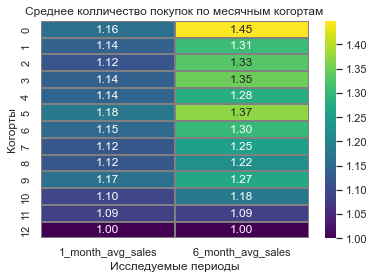

In [65]:
yticklabels = yticks_cohorts
plt.figure
ax = sns.heatmap(data = purchases_pivot[['1_month_avg_sales', '6_month_avg_sales']], annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
                 cmap= 'viridis')
plt.title('Среднее колличество покупок по месячным когортам')
ax.set_xlabel('Исследуемые периоды')
ax.set_ylabel('Когорты')
plt.show()

In [66]:
#
print('Среднее количество покупок на одного пользователя за 1 месяц: {:.2f}'.format(purchases_pivot
                                                                                    ['1_month_avg_sales'].mean()))
print('Среднее количество покупок на одного пользователя за 6 месяцев: {:.2f}'.format(purchases_pivot
                                                                                      ['6_month_avg_sales'].mean()))

Среднее количество покупок на одного пользователя за 1 месяц: 1.13
Среднее количество покупок на одного пользователя за 6 месяцев: 1.26


**Таким образом, среднее количество покупок одного пользователя за 6 месяцев составило 1.26, что больше данного показателя за июнь, который составил 1.13.** 

Далее рассчитаем средний чек, применяя группировку по времени совершения покупки. 

In [67]:
#Сгруппируем таблицу заказов по времени:
orders_receipt = orders.pivot_table(index = 'buy_ts', values = 'revenue', aggfunc = 'sum').reset_index()
orders_receipt.head()

,buy_ts,revenue
0,2017-06-01 00:10:00,17.00
1,2017-06-01 00:25:00,0.55
2,2017-06-01 00:27:00,0.37
3,2017-06-01 00:29:00,0.55
4,2017-06-01 07:58:00,0.37


In [68]:
print('Средний чек составил: {:.2f} у.е.'.format(orders_receipt['revenue'].mean()))

Средний чек составил: 5.48 у.е.


Посмотрим на распределение данного показателя во времени.

In [69]:
orders_receipt = orders_receipt.sort_values(by = 'buy_ts', ascending = True)

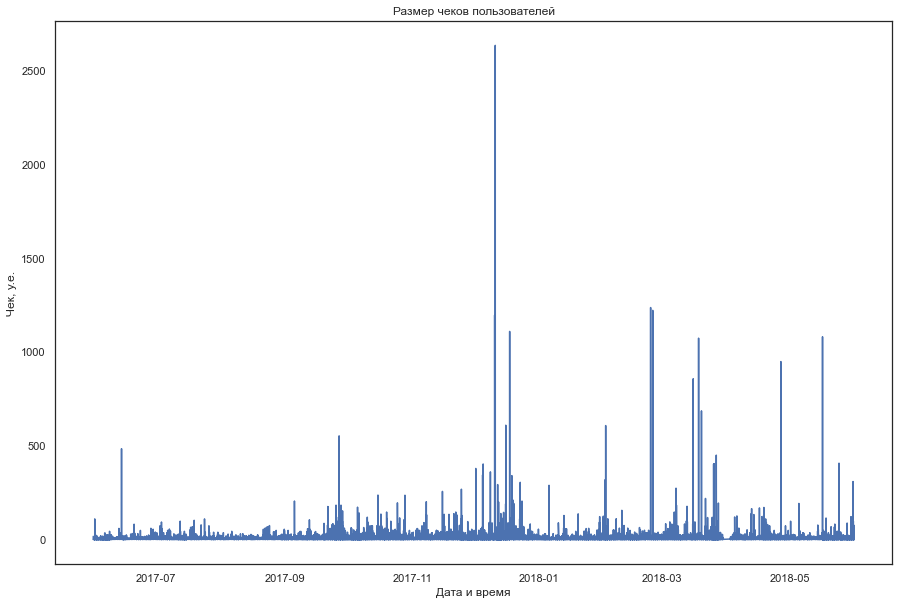

In [70]:
plt.figure(figsize = (15, 10))
sns.lineplot(data = orders_receipt, x = 'buy_ts', y = 'revenue')
plt.ylabel("Чек, у.е.")
plt.xlabel("Дата и время")
plt.title("Размер чеков пользователей")
plt.show()

Период около первых четырех месяцев имел меньший размер чеков по сравнению с последующими месяцами. Так, до сентября 2017 было меньше пиков (более дорогие покупки) и в целом размер чека визуально меньше, чем в остальные месяцы. 

Посмотрим, действительно ли средний чек за первые четыре месяца отличался от среднего чека за остальной период (альтернативная гипотеза), или изменения статистически незначительны (нулевая гипотеза):

In [71]:
orders_receipt_first4m = orders_receipt.query('buy_ts < "2017-10-01"')['revenue']
orders_receipt_rest = orders_receipt.query('buy_ts > "2017-09-30"')['revenue']


In [72]:
result = st.ttest_ind(orders_receipt_first4m, orders_receipt_rest, nan_policy = 'omit')
alpha = 0.05
print('p-значение: ', result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: средний чек за первые 4 месяца отличался от среднего чека за остальной период.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: средний чек за первые 4 месяца не отличался от среднего чека за остальной период.")

p-значение:  0.2390284762347312
Не получилось отвергнуть нулевую гипотезу: средний чек за первые 4 месяца не отличался от среднего чека за остальной период.


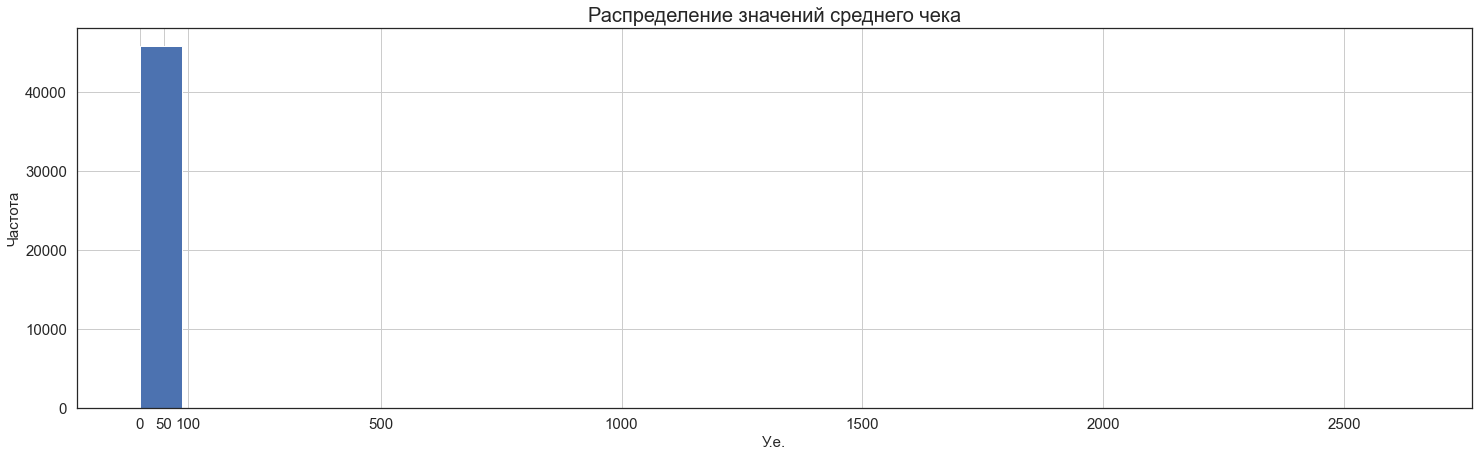

In [73]:
plt.figure(figsize = (25, 7))
ax = orders_receipt['revenue'].hist(bins = 30)
ax.set_xticks([0, 50, 100, 500, 1000, 1500, 2000, 2500])
plt.title('Распределение значений среднего чека', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('У.е.', fontsize = 15)
ax.set_ylabel('Частота', fontsize = 15)
plt.show()

Однако интересно, что размер большинства совершенных покупок не превышает 100 у.е.

In [74]:
print('Средний чек:', orders_receipt['revenue'].mean(), 'у.е.')

Средний чек: 5.48057663455887 у.е.


In [75]:
print('Средний чек:', orders_receipt['revenue'].mode(), 'у.е.')

Средний чек: 0    1.83
dtype: float64 у.е.


_____________________________________________________________________________
Следующим исследуемым показателям будет LTV (Lifetime value), отражающее количество денег приносимое пользователями. Выясним, как меняется LTV на покупателя по когортам.

Рассчитаеем средний LTV по когортам за 6 месяцев, включив в расчёт когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. 


In [76]:
expenses['dt'].describe()

count                    2542
unique                    364
top       2017-06-01 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [77]:
expenses['month'] = expenses['dt'].astype('datetime64[M]')


Получим месяц первой покупки каждого покупателя:

In [78]:
first_orders = orders.groupby('uid').agg({'purchase_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_purchase_month']
print(first_orders.head())


                uid first_purchase_month
0   313578113262317           2018-01-01
1  1575281904278712           2017-06-01
2  2429014661409475           2017-10-01
3  2464366381792757           2018-01-01
4  2551852515556206           2017-11-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [79]:
cohorts_size = (
    orders.groupby('first_purchase_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohorts_size.columns = ['first_purchase_month', 'n_buyers']
print(cohorts_size.head())


  first_purchase_month  n_buyers
0           2017-06-01      2023
1           2017-07-01      1923
2           2017-08-01      1370
3           2017-09-01      2581
4           2017-10-01      4340


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [80]:
cohorts_ltv = (
    orders.groupby(['first_purchase_month', 'purchase_month'])
    .agg({'revenue': 'sum'})
    .reset_index()
)
print(cohorts_ltv.head(20))


   first_purchase_month purchase_month   revenue
0            2017-06-01     2017-06-01   9557.49
1            2017-06-01     2017-07-01    981.82
2            2017-06-01     2017-08-01    885.34
3            2017-06-01     2017-09-01   1931.30
4            2017-06-01     2017-10-01   2068.58
5            2017-06-01     2017-11-01   1487.92
6            2017-06-01     2017-12-01   1922.74
7            2017-06-01     2018-01-01   1176.56
8            2017-06-01     2018-02-01   1119.15
9            2017-06-01     2018-03-01   1225.51
10           2017-06-01     2018-04-01   1155.66
11           2017-06-01     2018-05-01    519.62
12           2017-07-01     2017-07-01  11557.65
13           2017-07-01     2017-08-01    644.61
14           2017-07-01     2017-09-01   1199.05
15           2017-07-01     2017-10-01    690.31
16           2017-07-01     2017-11-01    339.97
17           2017-07-01     2017-12-01    300.08
18           2017-07-01     2018-01-01    231.16
19           2017-07

Создадим тблицу с первыми заказами:


In [81]:
first_orders = orders.groupby('uid').agg({'purchase_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_purchase_month']

cohort_sizes = (
    first_orders.groupby('first_purchase_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_purchase_month', 'n_buyers']

cohort_sizes.head()


,first_purchase_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


LTV - накопительный показатель. Добавим в таблицу данные о том, сколько людей первый раз совершили заказ  в каждый месяц:

In [82]:
report_ltv = pd.merge(cohort_sizes, cohorts_ltv, on='first_purchase_month')
print(report_ltv.head(13))


   first_purchase_month  n_buyers purchase_month   revenue
0            2017-06-01      2023     2017-06-01   9557.49
1            2017-06-01      2023     2017-07-01    981.82
2            2017-06-01      2023     2017-08-01    885.34
3            2017-06-01      2023     2017-09-01   1931.30
4            2017-06-01      2023     2017-10-01   2068.58
5            2017-06-01      2023     2017-11-01   1487.92
6            2017-06-01      2023     2017-12-01   1922.74
7            2017-06-01      2023     2018-01-01   1176.56
8            2017-06-01      2023     2018-02-01   1119.15
9            2017-06-01      2023     2018-03-01   1225.51
10           2017-06-01      2023     2018-04-01   1155.66
11           2017-06-01      2023     2018-05-01    519.62
12           2017-07-01      1923     2017-07-01  11557.65


Найдем валовую прибыль, умножив выручку на маржинальность (100%).

In [83]:
margin_rate = 1 #хоть и не имеет особого значения в данном случае

report_ltv['gp'] = report_ltv['revenue'] * margin_rate #gross profit
report_ltv['age'] = (
    report_ltv['purchase_month'] - report_ltv['first_purchase_month']
) / np.timedelta64(1, 'M')
report_ltv['age'] = report_ltv['age'].round().astype('int')
report_ltv.head()


,first_purchase_month,n_buyers,purchase_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Найдем LTV, разделив валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

In [84]:
report_ltv['ltv'] = report_ltv['gp'] / report_ltv['n_buyers']

output = report_ltv.pivot_table(
    index='first_purchase_month', columns='age', values='ltv', aggfunc='mean' 
)

output.cumsum(axis = 1).fillna('')


age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.64738,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.96896,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.23118,8.386854,
2017-08-01,5.276518,5.748511,6.206993,6.59827,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,,
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.25122,13.435227,,,
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,,,,
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,,,,,
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,,,,,,
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,,,,,,,
2018-02-01,4.156987,4.435262,4.513777,4.587921,,,,,,,,


Итоговый ltv найдем добавив столбец с суммой всех ltv за 6 месяцев:

In [85]:
def ltv_total_6m(row):
    ltv_sum = row.iloc[0:5].sum()
    return ltv_sum
output['ltv_6m'] = output.apply(ltv_total_6m, axis = 1)
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11,ltv_6m
first_purchase_month,,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856,7.624582
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,,7.504727
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,,7.092321
2017-09-01,5.644529,1.117586,0.52093,3.975792,0.400558,0.647067,0.701608,0.24315,0.184006,,,,11.659396
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.084816,0.11547,,,,,6.039594
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,,6.226437
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.31293,0.338047,,,,,,,7.301866
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,,,,,,,,4.940151
2018-02-01,4.156987,0.278274,0.078515,0.074144,,,,,,,,,4.587921


Найдем средний ltv по всем когортам, продолжительность жизни которых не менее 6 месяцев:

In [86]:
ltv6_mean = output.loc[:'2017-12-01']['ltv_6m'].mean()
print('Средний LTV за 6 месяцев: {:.2f}'.format(ltv6_mean), 'у.е.')

Средний LTV за 6 месяцев: 7.64 у.е.


**Таким образом, в среднем один покупатель приносит компании 7.64 у.е. за все время.**

Посмотрим на изменения данных с помощью тепловой карты:

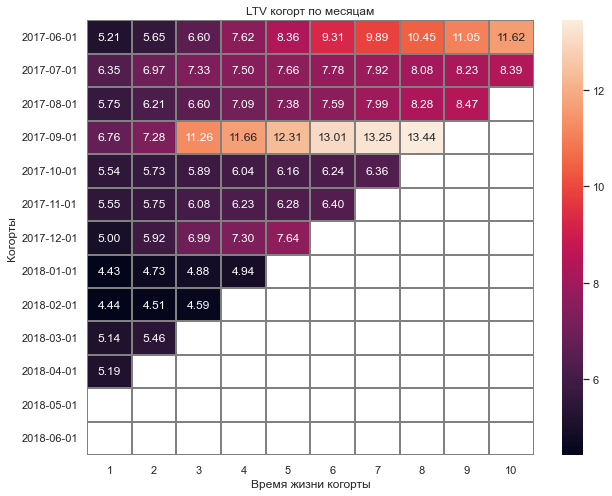

In [87]:
yticks_output = output.reset_index()
yticks_output = yticks_output['first_purchase_month'].dt.date.astype('str')
plt.figure(figsize = (10,8))
ax = sns.heatmap(data = output.cumsum(axis = 1).iloc[:, 1:11], annot=True, fmt='.2f', linewidths=1, linecolor='gray',yticklabels = yticks_output)
plt.title('LTV когорт по месяцам')
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Когорты')
plt.show()

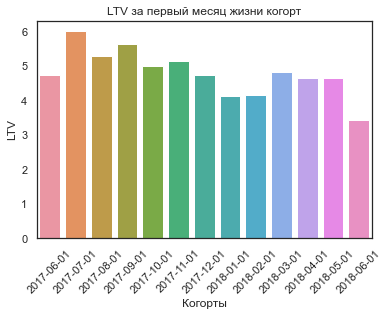

In [88]:
output_first_month = output.iloc[:, 0].reset_index()
output_first_month = output_first_month.rename(columns = {0:'first_lifetime_month'})
output_first_month['first_purchase_month'] = output_first_month['first_purchase_month'].astype('str')
plt.figure(figsize = (6,4))
ax = sns.barplot(data = output_first_month, x = 'first_purchase_month', y = 'first_lifetime_month')
plt.title('LTV за первый месяц жизни когорт')
ax.set_ylabel('LTV')
ax.set_xlabel('Когорты')
plt.xticks(rotation=45)
plt.show()

Можно сказать, что есть тренд по уменьшению ltv по месяцам жизни когорт.  Июньская и сентябрьская когорты наиболее успешны. Стоит подробнее изучить потенциальные факторы, вызвавшие увеличение прибыли в данных когортах явление с целью улучшения стратегии компании. 

Наблюдается снижение прибыли с каждого покупателя за первый месяц жизни к более поздним когортам. Данное наблюдение также следует изучить: что поменялось в стратегии компании после ноября 2017 года. 

### Маркетинговые метрики<a id = 'marketing_metrics'><a/>

Маркетинговые метрики важны для понимания, окупаются ли расходы и как быстро, а также, из какого источника пришли наиболее прибыльные покупатели. 

Для начала посчитаем, сколько всего денег потратила компания на маркетинг:

In [89]:
expenses_total = expenses['costs'].sum()
print('{:.2f} у.е.'.format(expenses_total))

329131.62 у.е.


Всего на маркетинг компания потратила 329 131.62 у.е.

Посмотрим на изменения затрат на маркетинг в течение года.

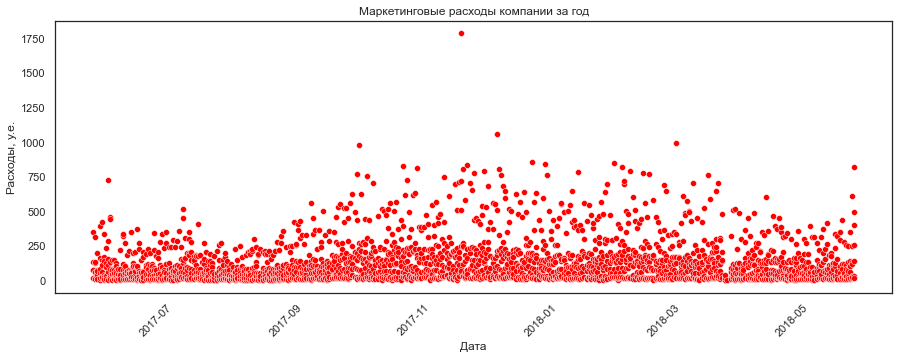

In [90]:
expenses = expenses.sort_values(by = 'dt')
plt.figure(figsize = (15, 5))
ax = sns.scatterplot(data = expenses, x = 'dt', y = 'costs', color = 'red')
plt.title('Маркетинговые расходы компании за год')
plt.xticks(rotation = 45)
ax.set_xlabel('Дата')
ax.set_ylabel('Расходы, у.е.')

plt.show()

Можно наблюдать увеличение расходов начиная с сентября 2017, и небольшой спад в мае 2018. 

Сгруппируем расходы в зависимости от источника:

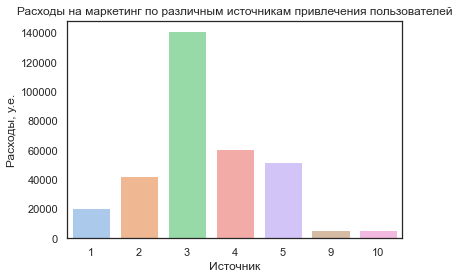

In [91]:
expenses_sources_total = expenses.groupby('source_id')['costs'].sum().reset_index()
plt.figure()
ax = sns.barplot(data = expenses_sources_total, x = 'source_id', y = 'costs', palette = 'pastel')
plt.title('Расходы на маркетинг по различным источникам привлечения пользователей')
ax.set_ylabel('Расходы, у.е.')
ax.set_xlabel('Источник')
plt.show()

Наиболее затратный источник - 3. Он более чем в два раза дороже обошелся компании, по сравнению с затратами на остальные источники. Наименее всего денег на маркетинг было потрачено на привлечеине пользователей через источники 9 и 10.

Далее рассчитаем средний CAC (Сustomer Acquisition Cost) на одного покупателя для всего проекта.

Сначала сгруппируем таблицу с расходами по месяцам:

In [92]:
monthly_expenses = expenses.groupby('month')['costs'].sum()
monthly_expenses

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

Добавим данные о расходах в таблицу report и посчитаем САС:

In [93]:
report_cac = pd.merge(
    report_ltv, monthly_expenses, left_on='first_purchase_month', right_on='month'
)
report_cac['cac'] = report_cac['costs'] / report_cac['n_buyers']
report_cac.head()

,first_purchase_month,n_buyers,purchase_month,revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.0,8.905091


Посмотрим на изменения САС на графике:

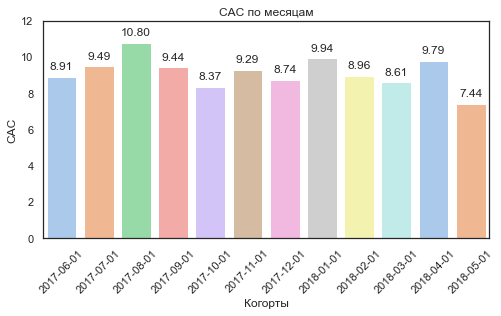

In [94]:
cac_pivot = report_cac.pivot_table(index = 'first_purchase_month', values = 'cac',
                                  aggfunc = 'mean').reset_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(data = cac_pivot, y = 'cac', x = cac_pivot['first_purchase_month'].astype('str'), 
                palette = 'pastel')
plt.title('CAC по месяцам')
plt.xticks(rotation = 45)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), 
               ha = 'center', 
               va = 'center', xytext = (0, 10), 
               textcoords = 'offset points')
plt.ylim(0, 12)
ax.set_xlabel('Когорты')
ax.set_ylabel('CAC')
plt.show()

Средние затраты на привлечение одного покупателя несильно изменялись по месяцам. Наиболее затратными были август 2017 (10.8 у.е.) и январь (9.94 у.е.) и апрель (9.79 у.е.) 2018. 

Посмотрим на CAC в зависимости от источников. Сначала получим таблицу с общими затратами по месяцам на разные источники:

In [95]:
#Найдем дату первого заказа
first_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order']
first_orders['first_order'] = first_orders['first_order'].astype('datetime64[D]')

In [96]:
#таблица с первыми источниками
first_sources = visits.sort_values('start_ts').groupby('uid').first()

In [97]:
#объединим таблицы:
first_orders = first_orders.merge(first_sources, on = 'uid')

In [98]:
first_orders.head()

,uid,first_order,device,end_ts,source_id,start_ts,date,month,week,year,session_duration,first_activity_date,first_activity_month,activity_month
0,313578113262317,2018-01-03,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18,9,38,2017,1080,2017-09-18 22:49:00,2017-09-01,2017-09-01
1,1575281904278712,2017-06-03,touch,2017-06-03 10:17:00,10,2017-06-03 10:13:00,2017-06-03,6,22,2017,240,2017-06-03 10:13:00,2017-06-01,2017-06-01
2,2429014661409475,2017-10-11,desktop,2017-10-11 17:27:00,3,2017-10-11 17:14:00,2017-10-11,10,41,2017,780,2017-10-11 17:14:00,2017-10-01,2017-10-01
3,2464366381792757,2018-01-28,desktop,2018-01-27 20:13:00,5,2018-01-27 20:10:00,2018-01-27,1,4,2018,180,2018-01-27 20:10:00,2018-01-01,2018-01-01
4,2551852515556206,2017-11-24,desktop,2017-11-24 10:14:19,5,2017-11-24 10:14:00,2017-11-24,11,47,2017,19,2017-11-24 10:14:00,2017-11-01,2017-11-01


In [99]:
first_orders_grouped = first_orders.groupby(['source_id','first_order']).agg({'uid':'count'})
first_orders_grouped.columns = ['total_buyers']
first_orders_grouped.head()

total_buyers
source_id first_order              
1         2017-06-01             14
          2017-06-02              7
          2017-06-03              7
          2017-06-04              3
          2017-06-05             18

In [100]:
orders_source_id = first_orders_grouped.merge(expenses, right_on = ['source_id', 'dt'],
                               left_on = ['source_id', 'first_order'])
orders_source_id.head()

,source_id,total_buyers,dt,costs,month
0,1,14,2017-06-01,75.20,2017-06-01
1,1,7,2017-06-02,62.25,2017-06-01
2,1,7,2017-06-03,36.53,2017-06-01
3,1,3,2017-06-04,55.00,2017-06-01
4,1,18,2017-06-05,57.08,2017-06-01


In [101]:
orders_source_id['cac'] = orders_source_id['costs'] / orders_source_id['total_buyers']

In [102]:
sources_cac = orders_source_id.groupby('source_id').agg({'cac':'mean'})
sources_cac

,cac
source_id,
1,9.489732
2,16.287024
3,15.580474
4,7.271743
5,8.336731
9,6.842532
10,6.555415


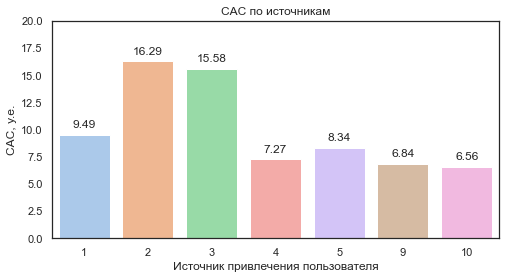

In [103]:
sources_cac = sources_cac.reset_index()
plt.figure(figsize = (8, 4))

ax = sns.barplot(data = sources_cac, y = 'cac', x = 'source_id', palette = 'pastel')

plt.title('CAC по источникам')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), 
               ha = 'center', 
               va = 'center', xytext = (0, 10), 
               textcoords = 'offset points')
plt.ylim(0, 20)
ax.set_xlabel('Источник привлечения пользователя')
ax.set_ylabel('CAC, у.е.')
plt.show()

Наиболее дорогим оказалось привлечение пользователей из второго (16.29 у.е. на пользователя) и третьего источников (15.58 у.е. на пользователя). Источники 9 (6,84 у.е.) и 10 (6,56 у.е.) наиболее экономичны. 

Перейдем к исследованию окупаемости бизнеса. Изучим значения ROMI по когортам и источникам и посмотрим, после какого периода когорты начинают окупаться. 

Для этого отдельно для каждого источника посчитаем LTV и CAC.

Сначала добавим первые источники к таблице orders:

In [104]:
first_sources_id = first_sources['source_id'].reset_index()
orders = orders.merge(first_sources_id, on = 'uid')

Далее создадим отдельные датафреймы с пользователями из разных источников и объединим их в одной таблице:

In [105]:
a = [1, 2, 3, 4, 5, 9, 10]
all_data = []
for i in a:
    x = orders.query('source_id == @i')
    all_data.append(x)
    
sources_7 = pd.concat(all_data, axis=0) 
    
sources_7.head()

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,purchase_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,1
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
10,2017-06-02 15:08:00,12.83,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
11,2017-06-04 13:06:00,17.11,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1


In [106]:
sources_7.head(30)

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,purchase_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,1
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
10,2017-06-02 15:08:00,12.83,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
11,2017-06-04 13:06:00,17.11,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
12,2017-06-07 11:06:00,7.33,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
13,2017-06-07 15:05:00,2.57,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
14,2017-06-09 13:15:00,3.97,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
15,2017-06-13 11:04:00,2.44,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1
16,2017-06-13 13:52:00,9.17,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,1


Напишем функцию для подсчета ltv в срезах данных:

In [107]:
def cohorts_by_sources(df):
    #Месяц первой покупки каждого покупателя:
    first_orders = df.groupby('uid').agg({'purchase_month': 'min'}).reset_index()
    first_orders.columns = ['uid', 'first_purchase_month']
    #n_buyers:
    cohort_sizes = first_orders.groupby('first_purchase_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_purchase_month', 'n_buyers']
    #cohorts
    cohorts = df.groupby(['first_purchase_month', 'purchase_month']).agg({'revenue':'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_purchase_month')
    report['gp'] = report['revenue']
    report['age'] = (report['purchase_month'] - report['first_purchase_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['gp'] / report['n_buyers']
    report
    return report

In [108]:
a = [1, 2, 3, 4, 5, 9, 10]
all_data = []
for i in a:
    x = sources_7.query('source_id == @i')
    result = cohorts_by_sources(x)
    result['source_id'] = i
    all_data.append(result)

report_sources = pd.concat(all_data, axis=0) 

In [109]:
report_sources.head()

,first_purchase_month,n_buyers,purchase_month,revenue,gp,age,ltv,source_id
0,2017-06-01,190,2017-06-01,1378.70,1378.70,0,7.256316,1
1,2017-06-01,190,2017-07-01,414.98,414.98,1,2.184105,1
2,2017-06-01,190,2017-08-01,419.43,419.43,2,2.207526,1
3,2017-06-01,190,2017-09-01,714.24,714.24,3,3.759158,1
4,2017-06-01,190,2017-10-01,811.20,811.20,4,4.269474,1


Добавим значения CAC и посчитаем ROMI:

In [110]:
report_sources = report_sources.merge(sources_cac, on = 'source_id')
report_sources.head()

,first_purchase_month,n_buyers,purchase_month,revenue,gp,age,ltv,source_id,cac
0,2017-06-01,190,2017-06-01,1378.70,1378.70,0,7.256316,1,9.489732
1,2017-06-01,190,2017-07-01,414.98,414.98,1,2.184105,1,9.489732
2,2017-06-01,190,2017-08-01,419.43,419.43,2,2.207526,1,9.489732
3,2017-06-01,190,2017-09-01,714.24,714.24,3,3.759158,1,9.489732
4,2017-06-01,190,2017-10-01,811.20,811.20,4,4.269474,1,9.489732


In [111]:
report_sources['romi'] = report_sources['ltv'] / report_sources['cac']

Построим сводные таблицы окупаемости:

In [112]:
a = [1, 2, 3, 4, 5, 9, 10]
for i in a:
    x = report_sources.query('source_id == @i')
    pivot = x.pivot_table(index = 'first_purchase_month',
                     columns = 'age', 
                     values = 'romi',
                     aggfunc = 'mean')
    print('Source', i)
    display(pivot.cumsum(axis=1).round(2))
    

Source 1


age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.76,0.99,1.23,1.62,2.07,2.29,2.56,2.83,3.07,3.24,3.37,3.55
2017-07-01,0.77,0.88,1.45,1.61,1.70,1.79,1.84,1.91,2.00,2.10,2.20,NaN
2017-08-01,0.79,0.92,1.02,1.12,1.23,1.30,1.38,1.66,1.89,1.97,NaN,NaN
2017-09-01,0.63,0.82,0.88,0.98,0.98,0.99,1.00,1.04,1.10,NaN,NaN,NaN
2017-10-01,0.63,0.75,0.77,0.81,0.82,0.83,0.85,0.88,NaN,NaN,NaN,NaN
2017-11-01,0.78,0.84,0.94,1.04,1.05,1.06,1.07,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.48,0.52,0.55,0.57,0.57,0.59,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.61,0.62,0.63,0.74,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.49,0.60,0.61,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source 2


age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.27,0.30,0.32,0.44,0.54,0.60,0.69,0.79,0.87,0.91,1.0,1.02
2017-07-01,0.52,0.56,0.57,0.59,0.61,0.63,0.64,0.65,0.66,0.67,0.7,NaN
2017-08-01,0.35,0.41,0.42,0.44,0.47,0.47,0.48,0.50,0.51,0.51,NaN,NaN
2017-09-01,0.51,1.01,1.15,1.21,1.30,1.36,1.56,1.61,1.64,NaN,NaN,NaN
2017-10-01,0.47,0.62,0.66,0.70,0.73,0.75,0.75,0.77,NaN,NaN,NaN,NaN
2017-11-01,0.43,0.48,0.51,0.56,0.58,0.59,0.60,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.64,1.21,1.89,2.08,2.27,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.27,0.33,0.44,0.46,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.33,0.37,0.39,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source 3


age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.28,0.29,0.30,0.32,0.33,0.35,0.35,0.36,0.36,0.36,0.36,0.37
2017-07-01,0.39,0.41,0.42,0.44,0.44,0.45,0.45,0.46,0.47,0.47,0.47,NaN
2017-08-01,0.33,0.34,0.35,0.36,0.37,0.37,0.38,0.38,0.39,0.39,NaN,NaN
2017-09-01,0.36,0.37,0.39,0.40,0.41,0.42,0.43,0.43,0.44,NaN,NaN,NaN
2017-10-01,0.31,0.34,0.34,0.35,0.36,0.36,0.36,0.37,NaN,NaN,NaN,NaN
2017-11-01,0.29,0.30,0.30,0.31,0.32,0.32,0.32,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.27,0.28,0.29,0.29,0.30,0.30,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.26,0.28,0.28,0.29,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.24,0.26,0.27,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source 4


age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.65,0.66,0.68,0.74,0.90,1.11,1.30,1.34,1.37,1.48,1.65,1.66
2017-07-01,0.76,0.77,0.78,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.86,NaN
2017-08-01,0.70,0.72,0.74,0.77,0.79,0.82,0.83,0.86,0.87,0.89,NaN,NaN
2017-09-01,0.66,0.72,0.76,0.80,0.81,0.84,1.02,1.05,1.06,NaN,NaN,NaN
2017-10-01,0.60,0.62,0.64,0.66,0.67,0.69,0.70,0.71,NaN,NaN,NaN,NaN
2017-11-01,0.71,0.80,0.81,0.87,0.89,0.90,0.93,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.57,0.59,0.60,0.61,0.62,0.63,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.52,0.54,0.55,0.56,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.56,0.58,0.58,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source 5


age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,0.59,0.70,0.76,0.86,0.94,0.98,1.08,1.15,1.22,1.33,1.35,1.37
2017-07-01,0.63,0.67,0.73,0.75,0.76,0.77,0.77,0.79,0.80,0.80,0.81,NaN
2017-08-01,0.61,0.70,0.80,0.88,1.01,1.08,1.13,1.16,1.19,1.21,NaN,NaN
2017-09-01,0.74,0.77,0.80,2.74,2.84,3.08,3.11,3.14,3.14,NaN,NaN,NaN
2017-10-01,0.61,0.64,0.65,0.67,0.68,0.69,0.71,0.72,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.57,0.58,0.59,0.61,0.61,0.62,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.60,0.62,0.63,0.63,0.64,0.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.52,0.58,0.63,0.63,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.52,0.53,0.54,0.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source 9


age,0,1,2,3,4,5,6,7,8,9,10
first_purchase_month,,,,,,,,,,,
2017-06-01,0.52,0.53,0.62,0.71,0.75,0.81,0.89,0.91,0.98,1.00,1.01
2017-07-01,0.65,0.68,0.77,0.84,0.89,0.90,0.94,0.95,1.01,1.02,1.03
2017-08-01,0.60,0.62,0.72,0.75,0.76,0.77,0.79,0.83,0.84,0.87,NaN
2017-09-01,0.63,0.78,0.87,0.99,1.07,1.09,1.18,1.28,1.41,NaN,NaN
2017-10-01,0.74,0.82,0.88,0.90,0.94,1.02,1.02,1.03,NaN,NaN,NaN
2017-11-01,0.55,0.57,0.59,0.63,0.65,0.66,0.66,NaN,NaN,NaN,NaN
2017-12-01,0.56,0.61,0.63,0.67,0.67,0.69,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.41,0.45,0.48,0.48,0.48,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.70,0.73,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Source 10


age,0,1,2,3,4,5,6,7,8,9
first_purchase_month,,,,,,,,,,
2017-06-01,0.37,0.39,NaN,NaN,NaN,NaN,NaN,NaN,0.39,NaN
2017-07-01,0.53,0.53,NaN,0.56,NaN,NaN,NaN,NaN,0.56,NaN
2017-08-01,0.76,0.78,0.83,NaN,NaN,NaN,NaN,0.85,NaN,0.86
2017-09-01,0.34,0.35,0.36,0.39,0.40,NaN,NaN,0.40,0.40,NaN
2017-10-01,0.40,0.41,0.41,0.42,0.42,0.42,0.43,0.43,NaN,NaN
2017-11-01,0.71,0.71,0.72,0.74,0.76,0.77,0.78,NaN,NaN,NaN
2017-12-01,0.58,0.60,NaN,NaN,NaN,0.61,NaN,NaN,NaN,NaN
2018-01-01,0.47,0.48,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.38,0.40,0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Таким образом, мы видим, что когорты большинства источников окупаются в течение года или раньше, а некоторые нет, а именно источников 3 и 10.  

Посмотрим на средний период, после которого расходы на маркетинг начинают окупаться среди пользователей из разных источников:

In [113]:
a = [1, 2, 3, 4, 5, 9, 10]
all_data = []
for i in a:
    x = report_sources.query('source_id == @i')
    pivot = x.pivot_table(index = 'first_purchase_month',
                     columns = 'age', 
                     values = 'romi',
                     aggfunc = 'mean')
    pivot['source_id'] = str(i)
    all_data.append(pivot)
roi_sources = pd.concat(all_data, axis=0) 
roi_sources.head(20)

age,0,1,2,3,4,5,6,7,8,9,10,11,source_id
first_purchase_month,,,,,,,,,,,,,
2017-06-01,0.764649,0.230155,0.232623,0.396129,0.449905,0.215934,0.272028,0.265789,0.239677,0.175425,0.126963,0.176046,1
2017-07-01,0.768396,0.115460,0.564255,0.158803,0.092554,0.094826,0.047090,0.068087,0.090315,0.103836,0.097783,NaN,1
2017-08-01,0.789629,0.126163,0.106459,0.101666,0.109518,0.070220,0.071675,0.280005,0.231111,0.082064,NaN,NaN,1
2017-09-01,0.633813,0.189869,0.058937,0.097458,0.004085,0.010046,0.008955,0.032337,0.062163,NaN,NaN,NaN,1
2017-10-01,0.634224,0.111260,0.025793,0.040868,0.006667,0.011402,0.019318,0.033801,NaN,NaN,NaN,NaN,1
2017-11-01,0.778831,0.060465,0.101539,0.094199,0.017205,0.011165,0.008505,NaN,NaN,NaN,NaN,NaN,1
2017-12-01,0.483079,0.032775,0.030429,0.025892,0.002802,0.010076,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-01-01,0.607902,0.009537,0.015231,0.102570,0.005194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2018-02-01,0.493854,0.105362,0.007097,0.038940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [114]:
roi_sources.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2017-06-01 to 2018-05-01
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   0          85 non-null     float64
 1   1          76 non-null     float64
 2   2          67 non-null     float64
 3   3          57 non-null     float64
 4   4          51 non-null     float64
 5   5          45 non-null     float64
 6   6          38 non-null     float64
 7   7          33 non-null     float64
 8   8          27 non-null     float64
 9   9          19 non-null     float64
 10  10         12 non-null     float64
 11  11         5 non-null      float64
 12  source_id  85 non-null     object 
dtypes: float64(12), object(1)
memory usage: 9.3+ KB


In [115]:
#выведем полученные данные:
a = ['1', '2', '3', '4', '5', '9', '10']
b = []
for i in a:
    x = roi_sources.query('source_id == @i')
    b.append(x.iloc[:, 0 : 11].cumsum(axis=1).mean(axis=0))
roi_mean = pd.concat(b, axis=1) 
roi_mean.columns = a
roi_mean

,1,2,3,4,5,9,10
age,,,,,,,
0,0.665402,0.399207,0.295600,0.628610,0.579954,0.585808,0.498491
1,0.786221,0.498857,0.320529,0.667883,0.624116,0.635618,0.517738
2,0.934976,0.612414,0.326184,0.680026,0.669901,0.669662,0.534648
3,1.014923,0.742238,0.337826,0.711582,0.921328,0.745820,0.526961
4,1.147123,0.847472,0.353421,0.758010,1.013105,0.778214,0.526128
5,1.265746,0.951159,0.367778,0.829564,1.120997,0.849839,0.599555
6,1.450456,0.787821,0.382743,0.936052,1.238558,0.914952,0.601083
7,1.662170,0.863086,0.400399,0.959390,1.391836,0.999479,0.560506
8,2.012696,0.918058,0.414062,1.037893,1.586075,1.064229,0.448699


Построим тепловую карту, чтобы лучше проанализировать окупаемость:

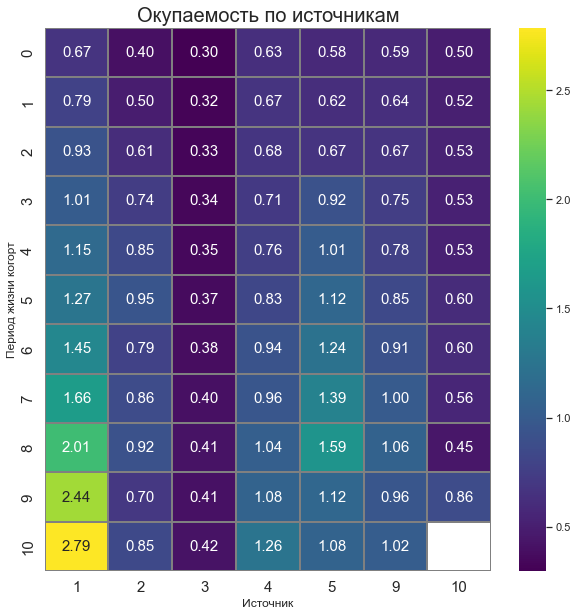

In [116]:
dates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.figure(figsize = (10, 10))
ax = sns.set(style='white')
plt.title('Окупаемость по источникам', fontsize = 20)
ax = sns.heatmap(roi_mean, annot=True, fmt='.2f', linewidths=1, linecolor='gray', 
                 cmap= 'viridis', annot_kws={"fontsize":15}, yticklabels = dates)
ax.tick_params(labelsize = 15)
ax.set_xlabel('Источник')
ax.set_ylabel('Период жизни когорт')
plt.show()

Таким образом, затраты на польователей из первого источника окупаются быстрее всего, и в среднем, это происходит на четвертый ммесяц. Следующий по окупаемости источник - пятый, окупается в среднем на пятый месяц. Источники 4 и 9 окупаются на 9-й и 8-й месяц соответственно. Наиболее неудачны источники 3 и 10, которые не окупаются вообще. 

# Выводы<a id = 'conclusions'><a/>

В ходе данного исследования, был проведен анализ данных отдела маркетинга Яндекс.Афиши и проанализировано поведение пользователей, доходы и расходы компании, а также выбраны потенциально прибыльные источники привлечения пользователей. 

1. В среднем на сайт за день заходит 908 человек, за неделю - 5716, а за месяц - 23228. Данные показатели изменялись в течение исследуемого периода, так, с августа 2017 года по декабрь 2017 года наблюдался рост числа уникальных пользователей заходящих на сайт: значения WAU достигли отметки  10586 чел. (47 неделя 2017 года), DAU - 3319 чел. (2017-11-24), MAU - 32797 чел. (ноябрь 2017 года). После указанного периода данные показатели стали уменьшаться. Большинство пользовательских сессий имели продолжительность 60 секунд.


2. Исследование Retenton Rate показало, что после первого месяца большинство пользователей (более 90%) не возвращаются. Наблюдалось уменьшение коэффициента удержания в более поздних когортах до 4.8% на второй месяц, что сигнализирует о том, что следует что-то менять, чтобы сохранить бизнес. Когорта июля 2017 года - наиболее успешная для компании, на 12-й месяц 4.5% пользователей остались, что почти в два раза выше показателей последних месяцов остальных когорт. В первые месяцы жизни хорошо показали себя когорты августа, сентября, октября и ноября 2017 года, хоть на конец жизни в них осталось лишь около 2% числа изначальных пользователей. 

 Таким образом, рекумендуется изучить изменения с первого месяца исследуемого периода и выявить потенциальные причины снижения удержания пользователей после первого месяца в долгосрочной перспективе. Также, стоит посмотреть, что отличало когорты с августа по ноябрь 2017 года от остальных, для выявления причин высокого удержания в краткосрочной перспективе. 

3.  Для анализа того, как пользователи совершают покупки на сайте, была найдена средняя продолжительность от первого визита на сайт до первой покупки, которая составила 249 минут, при этом, наиболее часто пользователи совершают первую покупку в течение одной и менее минут. 
 
 Как за один, так и за 6 месяцев в среднем один пользователь делал одну покупку. Размер большинства совершенных покупок не превышает 100 у.е. Среднее значение чека за исследуемый период - 5.48 у.е., при этом большинство чеков составляли 1.83 у.е.


4. Анализ LTV показал, что в среднем один покупатель приносит компании 7.64 у.е. за все время. Наблюдалось снижение прибыли с каждого покупателя за первый месяц жизни к более поздним когортам. Данное наблюдение следует изучить: что менялось в стратегии компании после сентября 2017 года. 

5. Всего на маркетинг за исследуемый период компания потратила 329 131.62 у.е.

  Наблюдалось увеличение расходов начиная с сентября 2017, и последующий небольшой спад в мае 2018. 
  
  Больше всего денег ушло на привлечение пользователей через источник 3. Он более чем в два раза дороже обошелся компании, по сравнению с затратами на остальные источники. Наименее всего денег на маркетинг было потрачено на привлечеине пользователей через источники 9 и 10. 
  
  В зависимости от средних затратх на привлечение одного покупателя по месяцам, наиболее затратными оказались август 2017 (10.8 у.е./чел.* месяц), январь (9.94 у.е./чел.* месяц) и апрель (9.79 у.е./чел.* месяц) 2018. В зависимости от источников, наиболее дорогим оказалось привлечение пользователей из второго (16.29 у.е./чел.* год) и третьего источников (15.58 у.е./чел.* год). Источники 9 (6,84 у.е./чел.* год) и 10 (6,56 у.е./чел.* год) наиболее экономичны.
  
  

6. Анализ ROMI, показателя окупаемости вложений на маркетинг, показал, что когорты большинства источников окупаются в течение года или раньше, а некоторые нет, а именно источников 3 и 10. Затраты на польователей из первого источника окупаются быстрее всего, и в среднем, это происходит на четвертый ммесяц. Пятый источник окупается в среднем на пятый месяц. Источники 4 и 9 окупаются на 9-й и 8-й месяц соответственно. 

 Эти данные свидетельствуют о том, что больше всего было вложено в 3-й источник, и в итоге он не окупился. Следует выявить потенциальные причины этого явления. Также, при наименьших затратах на источник 10, вложения так и не окупились. Рекомендуется снизить вложения в источники 3 и 10.
 
 Однако, первый источник в среднем окупается на четвертый месяц, хотя вложения в него менее 20000 у.е., что занимает третье место после источников  и 10. Рекомендуется увеличить вложения на 1 источник. 
 
 5, 4 и 9 источники, также могут быть потенциально прибыльными. Однако, следует провести более детальный анализ пользователей приходящих из данных источников. 